In [1]:
import cv2
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d,art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib notebook

In [2]:
#Load Preliminary Data for plotting 
plotarg=np.load("data/plotarg.npz")
vertices=plotarg['vertices']
pnparg = np.load("data/pnparg.npz")
cameraMatrix = pnparg['cameraMatrix']
poly3d=plotarg['poly3d']

In [3]:
#Set the image path
cwd = os.getcwd()
image_path=os.path.join(cwd,"task3")
image_list=os.listdir(image_path)
image_list_path=[os.path.join(image_path,x) for x in image_list]

if not os.path.exists('sol_3'):
    os.makedirs('sol_3')
    
if not os.path.exists('sol_3/cameraview'):
    os.makedirs('sol_3/cameraview')
    
if not os.path.exists('sol_3/box'):
    os.makedirs('sol_3/box')

In [4]:
#Adapted from https://www.scratchapixel.com/lessons..
#/3d-basic-rendering/minimal-ray-tracer-rendering-simple-shapes/ray-box-intersection

#Algorithm to find the intersection of the ray with the box

def ray_box_intersection(intercept,ray_direction):
    #Function to find the intersection and the distance measure
    flag= 1
    mincoordinates=np.array([0,0,0]).reshape(3,1)
    maxcoordinates=np.array([0.165,0.063,0.093]).reshape(3,1)
    
    tmin=(mincoordinates[0]-intercept[0])/ray_direction[0]
    tmax=(maxcoordinates[0]-intercept[0])/ray_direction[0]
    
    if (tmin>tmax):
        tmax,tmin=tmin,tmax

    tymin=(mincoordinates[1]-intercept[1])/ray_direction[1]    
    tymax=(maxcoordinates[1]-intercept[1])/ray_direction[1]    
    
    if (tymin>tymax):
        tymax,tymin=tymin,tymax
        
    if ((tmin > tymax) or (tymin > tmax)) :
        flag=0
        
    if (tymin > tmin): 
        tmin = tymin

    if (tymax < tmax) :
        tmax = tymax

    tzmin=(mincoordinates[2]-intercept[2])/ray_direction[2]    
    tzmax=(maxcoordinates[2]-intercept[2])/ray_direction[2]    
    
    if (tzmin > tzmax):
        tzmax,tzmin=tzmin,tzmax
        
    if ((tmin > tzmax) or (tzmin > tmax)):
        flag=0
        
    if (tzmin > tmin): 
        tmin = tzmin
        
    if (tzmax < tmax): 
        tmax = tzmax   
        
    if(tmin>tmax):
        tmin,tmax=tmax,tmin
    return flag,tmin    

In [5]:
#Returns all the SIFT keypoints and the descriptors in the entire image
def all_sift_points(image_list_path,idx):
    
    #Returns all the sift keypoints and the descriptors
    img = cv2.imread(image_list_path[idx])
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    (kp, des) = sift.detectAndCompute(gray, None)
    return kp,des

In [6]:
#Function that returns the list of all SIFT keypoints in 3D ,2D and the descriptors belonging 
#to the box
def sift_finder(rvec_matrix_init,tvec_init,idx):
    kp,des=all_sift_points(image_list_path,idx)
    kp_3d_init=[]
    des_init=[]
    kp_2d_init=[]
    for i in range(len(kp)):
        flag=1
        kp_point=kp[i]
        des_point=des[i]
        camera_center=-np.matmul(np.linalg.inv(np.matmul(cameraMatrix,rvec_matrix_init)),np.matmul(cameraMatrix,tvec_init))
        intercept = camera_center.reshape(3, 1)
        kp_pt = np.array([kp_point.pt[0], kp_point.pt[1], 1]).reshape(3, 1)
        ray_direction = np.matmul(np.linalg.inv(np.matmul(cameraMatrix, rvec_matrix_init)), kp_pt)
        flag,tmin = ray_box_intersection(intercept, ray_direction)
        if(flag==1):
                kp_3d_point = intercept+tmin*ray_direction
                kp_3d_init.append(kp_3d_point)
                des_init.append(des_point)
                kp_2d_init.append(kp_pt)
    return np.array(kp_3d_init),np.array(kp_2d_init),np.array(des_init)

In [7]:
#Returns all the SIFT keypoints and the descriptors in the entire image

def target_sift(idx):
    target_img = cv2.imread(image_list_path[idx])
    target_gray = cv.cvtColor(target_img, cv.COLOR_BGR2GRAY)
    target_sift = cv2.xfeatures2d.SIFT_create()
    (target_kp, target_des) = target_sift.detectAndCompute(target_gray, None)
    return target_kp,target_des

In [8]:
#Runs the brute force matchers and sorts the match by minimum distance.Returns the matched indices of the origin
#image and target image

def matcher(des_org,target_des,num_matches):
    bf = cv2.BFMatcher()
    matches = bf.match(des_org,target_des)
    sorted_matches = sorted(matches, key = lambda x:x.distance)
    if(num_matches==100000):
        num_matches=len(matches)
    selected_matches=sorted_matches[0:num_matches]
    target_index=np.array([item.trainIdx for item in selected_matches])
    origin_index=np.array([item.queryIdx for item in selected_matches])
    unique_idx=np.unique(target_index,return_index=True)[1]
    target_index=target_index[unique_idx]
    origin_index=origin_index[unique_idx]
    num_matches=np.unique(target_index).shape[0]
    return origin_index,target_index,num_matches

In [9]:
#Get the 3D coordinates from the matched SIFT points in the database

def get_3d_points(origin_index,kp_3d_org,num_matches):
    objectPoints=np.zeros((num_matches,3)).astype(np.float64)
    for (i,item) in enumerate(origin_index):
            objectPoints[i]=(kp_3d_org[item]).reshape(1,3)
    return objectPoints       

In [10]:
#Get the 2D points in the target image from the matched SIFT points of the target image

def get_2d_points(target_index,num_matches,target_kp):
    imagePoints=np.zeros((num_matches,2)).astype(np.float64)
    for (i,item) in enumerate(target_index):
            imagePoints[i][0],imagePoints[i][1]=target_kp[item][0],target_kp[item][1]
    return imagePoints        

In [11]:
#Wrapper function to return the 3D and 2D correspondences
def find_correspondences(kp_3d,des,des_org,kp_3d_org,num_matches=200):
    target_kp,target_des=kp_3d,des
    origin_index,target_index,num_matches=matcher(des_org,target_des,num_matches)
    objectPoints=get_3d_points(origin_index,kp_3d_org,num_matches)
    imagePoints=get_2d_points(target_index,num_matches,target_kp)
    return objectPoints,imagePoints

In [12]:
#Reprojection error function definition
def F(x):
    rvec_matrix=x[0:3].reshape(3,1)
    tvec_matrix=x[3:6].reshape(3,1)
    obj_temp= np.load("data/obj_temp.npz")
    objectPoints = obj_temp['objectPoints']
    imagePoints = obj_temp['imagePoints']
    rvec_matrix=cv2.Rodrigues(rvec_matrix)[0]
    a=np.matmul(cameraMatrix,np.matmul(rvec_matrix,objectPoints.T)+tvec_matrix).T
    b=np.ones((a.shape[0],2))
    for i in range(b.shape[0]):
        b[i,0]=a[i,0]/a[i,2]
        b[i,1]=a[i,1]/a[i,2]
    c=np.sum(np.square(b-imagePoints))    
    
    return c


In [13]:
def optimzer(init_x,objectPoints,imagePoints):
    import scipy.optimize
    np.savez('data/obj_temp.npz',
         objectPoints=objectPoints,
         imagePoints=imagePoints,
         )
    sol = scipy.optimize.minimize(F, init_x)
    x=sol.x
        
    #x=x.reshape((4,3))
    rvec_matrix=x[0:3].reshape(3,1)
    tvec_matrix=x[3:6].reshape(3,1)
    return rvec_matrix,tvec_matrix

In [14]:
#Find the 2D coordinates of the vertices
def image_point_finder(rvec_matrix,tvec):
    image_points=np.zeros((8,2))
    for i in range(8):
        world_point=vertices[i].reshape(3,1)
        image_point=np.matmul(cameraMatrix,np.matmul(rvec_matrix,world_point)+tvec)
        image_points[i][0]=image_point[0]/image_point[2]
        image_points[i][1]=image_point[1]/image_point[2]
    return image_points

In [15]:
#Plot the bounding box
def pose_plotter(image_points,idx):
    img = cv2.imread(image_list_path[idx])
    implot = plt.imshow(img)
    edges=np.array([2,3,2,6,6,7,3,7,1,0,1,5,4,5,4,0,3,0,7,4,5,6,1,2]).reshape(12,2)
    for e in range(12):
        x=(image_points[edges[e][0]][0],image_points[edges[e][1]][0])
        y=(image_points[edges[e][0]][1],image_points[edges[e][1]][1])
        plt.plot(x,y,'ro-')
        plt.axis('off')
    plt.savefig("sol_3/box/"+image_list[idx],bbox_inches = 'tight',pad_inches = 0)
    plt.close()


In [16]:
#Wrapper function to plot the bounding boxes
def solution_plotter(rvec_matrix,tvec_matrix,new_idx):
    image_points=image_point_finder(rvec_matrix,tvec_matrix)
    pose_plotter(image_points,new_idx)

In [17]:
def trajectory_plot(rvec_matrix,tvec_matrix,new_idx):
    fig = plt.figure()
    plt.ion()
    plt.draw()
    ax = plt.axes(projection="3d")
    world_origin = np.array((0, 0, 0)).reshape(3, 1).astype(np.int)
    ax.set_xlim(-0.6,0.6)
    ax.set_ylim(-0.6,0.6)
    ax.set_zlim(-0.6,0.6)
    plt.axis('off')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.scatter3D(0,0,0,c="limegreen",marker="o",s=25)
   
    rvec=rvec_matrix
    tvec=tvec_matrix
    ax.add_collection3d(Poly3DCollection(poly3d,facecolors='w',linewidths=1,alpha=0.5,edgecolor='b'))
    start_point=-np.matmul(np.linalg.inv(np.matmul(cameraMatrix,rvec)),np.matmul(cameraMatrix,tvec))
    ax.scatter3D(start_point[0],start_point[1],start_point[2],c="red",marker="o",s=25)
    
    image_name="sol_3/cameraview/"+str(new_idx)+".png"
    plt.savefig(image_name,bbox_inches = 'tight',pad_inches = 0)   

In [18]:

def sol(idx,new_idx):
    load_str="data/sol3_im"+str(idx)+".npz"
    a3sol= np.load(load_str)
    rvec_matrix_init=a3sol["rvec_init"]
    tvec_init=a3sol["tvec_init"]

    
    kp_3d_init,kp_2d_init,des_init=sift_finder(rvec_matrix_init,tvec_init,idx)
    kp_3d,kp_2d,des=sift_finder(rvec_matrix_init,tvec_init,new_idx)
    objectPoints,imagePoints=find_correspondences(kp_2d,des,des_init,kp_3d_init,num_matches=30)#200)
  
    init_x=np.ones((6,1))
    rvec_matrix_init=cv.Rodrigues(rvec_matrix_init)
    rvec_matrix_init = np.array(rvec_matrix_init[0])
    init_x[0:3]=rvec_matrix_init
    init_x[3:6]=tvec_init
    
    rvec_matrix,tvec_matrix=optimzer(init_x,objectPoints,imagePoints)
    rvec_matrix=cv.Rodrigues(rvec_matrix)
    rvec_matrix = np.array(rvec_matrix[0])
    
    solution_plotter(rvec_matrix,tvec_matrix,new_idx)
    camera_point=-np.matmul(np.linalg.inv(np.matmul(cameraMatrix,rvec_matrix)),np.matmul(cameraMatrix,tvec_matrix))
    
    np.savez("data/sol3_im"+str(new_idx)+".npz",
        rvec_init=rvec_matrix,
        tvec_init=tvec_matrix,
        )

    return  np.ravel(camera_point)
   
    

<IPython.core.display.Javascript object>


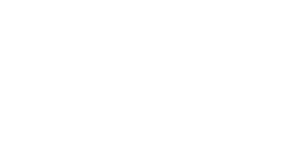

0


<IPython.core.display.Javascript object>


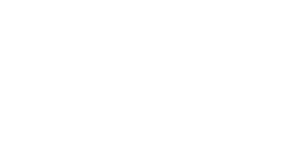

1


<IPython.core.display.Javascript object>


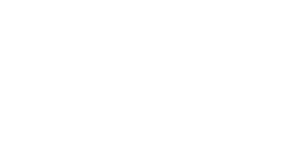

2


<IPython.core.display.Javascript object>


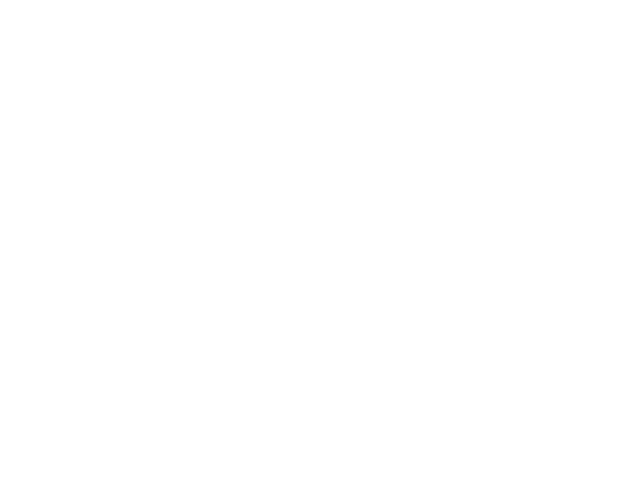

3


<IPython.core.display.Javascript object>


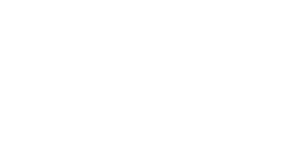

4


<IPython.core.display.Javascript object>


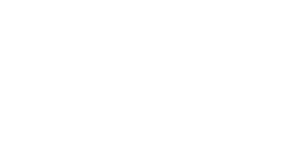

5


<IPython.core.display.Javascript object>


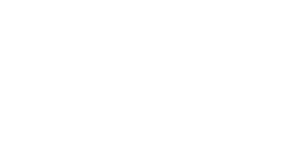

6


<IPython.core.display.Javascript object>


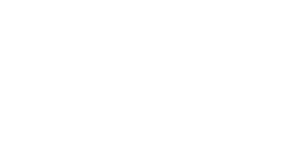

7


<IPython.core.display.Javascript object>


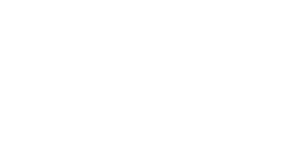

8


<IPython.core.display.Javascript object>


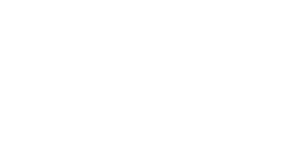

9


<IPython.core.display.Javascript object>


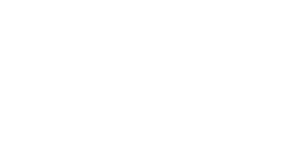

10


<IPython.core.display.Javascript object>


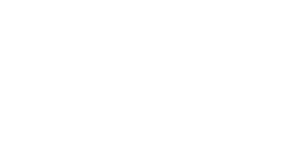

11


<IPython.core.display.Javascript object>


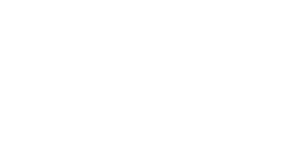

12


<IPython.core.display.Javascript object>


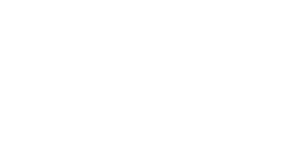

13


<IPython.core.display.Javascript object>


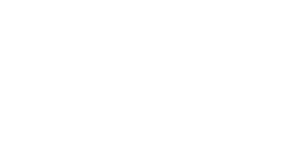

14


<IPython.core.display.Javascript object>


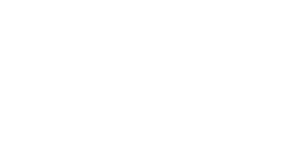

15


<IPython.core.display.Javascript object>


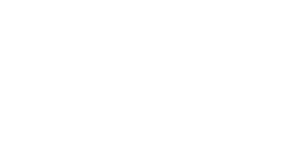

16


<IPython.core.display.Javascript object>


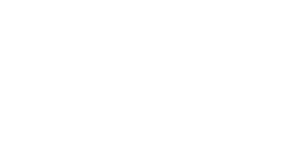

17


<IPython.core.display.Javascript object>


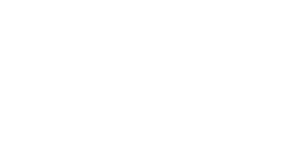

18


<IPython.core.display.Javascript object>


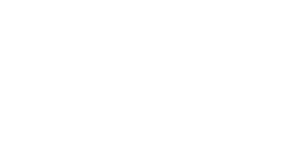

19


<IPython.core.display.Javascript object>


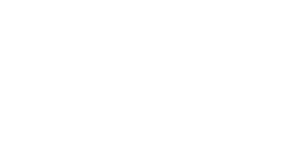

20


<IPython.core.display.Javascript object>


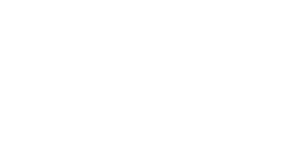

21


<IPython.core.display.Javascript object>


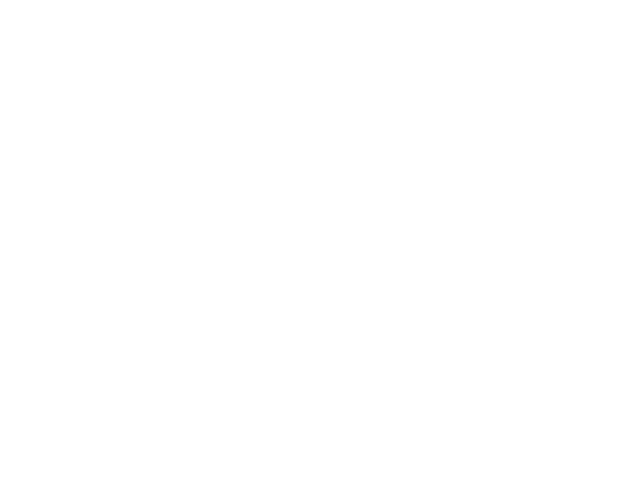

22


<IPython.core.display.Javascript object>


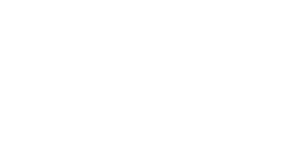

23


In [19]:
camera_points=np.zeros((24,3))
for i in range(24):
    camera_points[i]=sol(i,i+1)
    print(i)


<IPython.core.display.Javascript object>


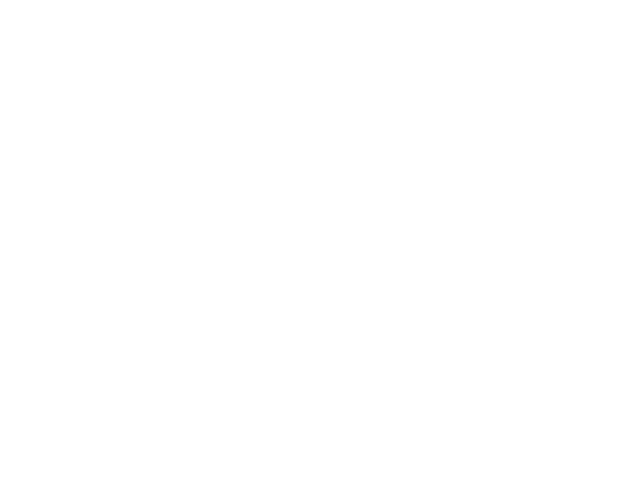

In [20]:
def trajectory_plot(camera_points):
    fig = plt.figure()
    plt.ion()
    plt.draw()
    ax = plt.axes(projection="3d")
    world_origin = np.array((0, 0, 0)).reshape(3, 1).astype(np.int)
    ax.set_xlim(-0.6,0.6)
    ax.set_ylim(-0.6,0.6)
    ax.set_zlim(-0.6,0.6)
    plt.axis('off')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.scatter3D(0,0,0,c="limegreen",marker="o",s=25)
       
    for i in range(24):
        ax.scatter3D(camera_points[i][0],camera_points[i][1],camera_points[i][2],c="red",marker="o",s=10)
        
    ax.add_collection3d(Poly3DCollection(poly3d,facecolors='w',linewidths=1,alpha=0.5,edgecolor='b'))
    ax.view_init(elev=90, azim=0)
    image_name="sol_3/trajectory.png"
    plt.savefig(image_name,bbox_inches = 'tight',pad_inches = 0)   
    
    
    ax.view_init(elev=0, azim=270)
    image_name="sol_3/trajectory2.png"
    plt.savefig(image_name,bbox_inches = 'tight',pad_inches = 0)   
 
    ax.view_init(elev=45, azim=270)
    image_name="sol_3/trajectory3.png"
    plt.savefig(image_name,bbox_inches = 'tight',pad_inches = 0)   
 
trajectory_plot(camera_points)    